In [1]:
%matplotlib inline
import numpy as np
pi = np.pi

# Our Strategy
We are faced with the serious problem that Rigatoni is inheretly non-linear: we must switch from using the motor to accelerate the car to using the brakes to decelerate the car.

We will address this by creating two completely separate controllers. One will command the motor voltage; the other will command the braking force. Each will operate independently of the other and we will simply ignore the brake controller when it commands acceleration and the motor controller when it attempts to slow the car. Since the brakes cannot accelerate the car and the motor cannot decelerate the car we hope that together we will achieve effective control.

# Modeling the car physics

## Definitions

### Electrical
* $\tau$: motor torque, Nm
* $\omega$: motor rotational speed, rad/s
* $V$: voltage across the motor terminals (will be $u$ when we construct the controller)
* $I$: motor current
* $R$: Resistance of the motor windings
* $K_t$: Motor torque constant in $\frac{N m}{A}$
* $K_v$: Motor velocity constant in $\frac {V s}{radians}$

### Mechanical
* $v$: velocity of the car in m/s
* $a$: acceleration of the car in $\frac{m}{s^2}$
* $m$: mass of the car in kg
* $d$: drag coefficient of the car in $\frac{Ns}{m}$
* $F_{net}$: Net force on the car in N
* $F_m$: The force the motor applies to the car through the wheels in N. Proportional to motor torque.
* $F_b$: The force the brake applies to the car through the wheels in N.
* $r_w$: car wheel radius in m
* $G_r$: gear ratio, expressed as shaft gear/motor gear. Larger than 1.
* $\omega_{axle}$: rotational speed of the rear drive axle in rad/s
* $\tau_{axle}$: torque applied by motor/chain to the rear drive axle in Nm

## Modeling the motor
[DC motor modeling](https://pages.mtu.edu/~wjendres/ProductRealization1Course/DC_Motor_Calculations.pdf)

We will use the following equivalent circuit model for the brushed DC motor:

![motor model](dc-motor-equivalent-circuit.png "https://www.precisionmicrodrives.com/content/dc-motor-speed-voltage-and-torque-relationships/")

Ignoring the effects of the inductance, the fundamental equations are:
$$\tau = K_tI$$
$$V = V_{EMF} + IR$$
$$V_{EMF} = K_v \omega$$

Rearranging, we have:
$$V = K_v \omega + IR$$

or
$$I = \frac{V - K_v \omega}{R}$$

Plugging this back in, we arrive at the final equation for torque in terms of voltage and rotational speed:
$$\tau = K_t\frac{V - K_v \omega}{R} = -\frac{K_t K_v \omega}{R} + \frac{K_t V}{R}$$

### Converting motor torque and angular velocity to linear force and velocity
At the rear drive shaft we have
$$\omega_{axle} = \frac{\omega}{G_r}$$
$$\tau_{axle} = G_r \tau$$

Then
$$v = r_w \omega_{axle} = \frac{r_w \omega}{G_r}$$
$$F_m = \frac{\tau_{axle}}{r_w} = \frac{G_r}{r_w} \tau = \frac{G_r K_t}{r_w} I$$

Rewriting the first equation,
$$\omega = \frac{G_r}{r_w} v$$

## Modeling the car's physics
![Car model](car_sum_forces.png)

Using Newton's Law:
$$ma = F_{net} = F_m - dv - F_b$$

Combining with the above motor modeling:
$$ma = \frac{G_r}{r_w} \tau - dv - F_b = \frac{G_r}{r_w}(-\frac{K_t K_v \omega}{R} + \frac{K_t V}{R}) - dv - F_b = \frac{G_r}{r_w}(-\frac{K_t K_v \frac{G_r}{r_w} v}{R} + \frac{K_t V}{R}) - dv - F_b$$

Simplifying
$$ma = -\frac{K_t K_v G_r^2 v}{r_w^2 R} v - dv + \frac{G_r K_t}{r_w R} V - F_b = -(\frac{K_t K_v G_r^2}{r_w^2 R} + d) v + \frac{G_r K_t}{r_w R} V - F_b$$

Placing in canonical form
$$\dot{v} = a = -(\frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}) v + \frac{G_r K_t}{r_w R m} V - \frac{1}{m} F_b$$

### Unified equation for simulation
Lumping into constants:
$$ \dot{v} = -\gamma_{speed} v + \gamma_{volt} V - \gamma_{brake} F_b $$

where
$$ \gamma_{speed} = \frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m} $$
$$ \gamma_{volt} = \frac{G_r K_t}{r_w R m} $$
$$ \gamma_{brake} = \frac{1}{m} $$

## The results

### Motor Only
Assuming the brake is applying 0 force
$$\dot{v} = -(\frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}) v + \frac{G_r K_t}{r_w R m} V$$

Lumping everything into constants,
$$ \dot{v} = -\gamma_{1m} v + \gamma_{2m} V $$

where
$$\gamma_{1m} = \frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}$$
$$\gamma_{2m} = \frac{G_r K_t}{r_w R m}$$

#### Units of $K_v$
$K_v$ is given in $\frac{V}{RPM} = \frac{V}{\frac{rev}{min}} = \frac{V min}{rev}$. Converting: $\frac{V min}{rev} \frac{60 sec}{min} \frac{rev}{2 \pi radian} = \frac{V s}{radian}$ as desired.
 

In [2]:
#Define mechanical constants
m = 100   #Sam said 200-25o pounds
Gr = 64/22 #Gear ratio
rw = 0.27/2 #Tire radius
d = 10 #TODO: find what the real drag constant is

#Define electrical constants
R = 0.035  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms
Kv = 0.0132 * 60/(2*pi)
Kt = 0.1260  #0.1260 design


gamma_1m = Kt*Kv*Gr**2/(rw**2 * R*m) + d/m
gamma_2m = Gr*Kt/(rw*R*m)

print(gamma_1m)
print(gamma_2m)

2.2071471415091826
0.7757575757575756


### Brakes Only
We have
$$\dot{v} = a = -\frac{d}{m} v - \frac{1}{m} F_b$$

Lumping everything into constants:
$$ \dot{v} = -\gamma_{1b} v + \gamma_{2b} F_b $$

where
$$\gamma_{1b} = \frac{d}{m}$$
$$\gamma_{2b} = -\frac{1}{m}$$

In [3]:
gamma_1b = d/m
gamma_2b = -1/m
print(gamma_1b)
print(gamma_2b)

0.1
-0.01


# Creating the controller
Since the equations for motor and brakes have identical forms, we shall design the controller for the motor and then simply change a few constants for the brakes.

Unfortunately, we do not have direct measurements of the car's velocity. We only measure the car's position with an encoder, so we will need an estimator to deduce the car's velocity from that. We will discuss this below, under Creating the Estimator.

It turns out that it is perfectly acceptable to do this - linear algebra shows that the overall system converges as fast as the slower of the regulator (our PI controller) and estimator. We shall design the estimator to converge much faster than the regulator, so we can ignore the effects of the estimator when designing the regulator.

Both controllers are 2nd order so we shall place the poles for each in the same spots:

In [4]:
desired_poles = [-2, -2.01]

## Definitions
### Variables
 * $\sigma$ is the error integral in $\frac{m}{s} s = m$
 * $r$ is the car's target (reference) velocity
 * $x$ is our system state variable velocity in $\frac{m}{s}$. This is usually a vector, but our system is first-order, so it is a scalar.
 * $\hat{x}$ is our estimated velocity in $\frac{m}{s}$ from the estimator.
 * $y$ is our system output variable velocity in $\frac{m}{s}$ (Yes, $x$ and $y$ are the same)

#### Motor Controller
 * $u_m$ is the voltage output from the controller in volts. The same thing as $V$ before.
 * $u_{ref,m}$ and $x_{ref,m}$ are reference values of $u_m$ and $x$ derived from plant inversion

### Brake Controller
 * $u_b$ is the voltage output from the controller in volts. The same thing as $F_b$ before.
 * $u_{ref,b}$ and $x_{ref,b}$ are reference values of $u$ and $x$ derived from plant inversion

### Constants
 * $n$ is the system order (1 for us).
 * $A_m$, $B_m$, $C_m$ are all matricies that represent the car's physics if the motor is accelerating the car and the brake is disengaged
 * $A_b$, $B_b$, $C_b$ are all matricies that represent the car's physics if the brake is stopping the car and the motor is coasting
 * $k_{1m}$ is the P gain of our motor controller. This is usually a matrix, but $x$ and $u_m$ are scalars so $k_{1m}$ is scalar too.
 * $k_{2m}$ is the I gain of our motor controller. This is a scalar.
 * $k_{1b}$ is the P gain of our brake controller. This is usually a matrix, but $x$ and $u_b$ are scalars so $k_{1b}$ is scalar too.
 * $k_{2b}$ is the I gain of our brake controller. This is a scalar.

## The Motor Controller

### Converting the model to state-space form

In order to more easily use our control-design machinery, we shall place the model in state-space form:
$$ \dot{x} = A_m x + B_m u_m $$
$$ y = C_m x $$

In [5]:
Am = -gamma_1m
Bm = gamma_2m
Cm = 1

### The controller equations
We shall implement PI trajectory-following control with state feedback

$$ u = u_{ref} - k_{1m} (x - x_{ref}) - k_{2m} \sigma $$
$$ \dot{\sigma} = y - r $$

We have no need of an estimator because we directly measure the state variable, velocity, with our speed sensor.

### Determining the gains $k_{1m}$ and $k_{2m}$
It can be shown that the overall system eigenvalues, which control how fast the car settles to the desired velocity, are given by the eigenvalues of
$$\mathscr{A_m} - \mathscr{B_m}\mathscr{K_m}$$

There are $$n + 1$$ eigenvalues to place.

$\mathscr{A_m} = \begin{pmatrix}A_m & 0 \\C_m & 0\end{pmatrix}$ is a square matrix, $\mathscr{B_m} = \begin{pmatrix}B_m \\ 0\end{pmatrix}$ is a column vector, and 
$\mathscr{K_m} = \begin{pmatrix}k_{1m} & k_{2m}\end{pmatrix}$ is a row vector.

#### Check for controllability and commandability
We can place the eigenvalues of $\mathscr{A_m} - \mathscr{B_m}\mathscr{K_m}$ anywhere we want provided that $A_m$ and $B_m$ are controllable and commandable, which is identical to checking if $\mathscr{A_m}$ and $\mathscr{B_m}$ are controllable.

$\mathscr{A_m}$ and $\mathscr{B_m}$ are controllable if and only if $|\mathscr{C_m}| \neq 0$, where $\mathscr{C_m}$ is a square matrix:
$$\mathscr{C_m} = \begin{pmatrix} B & AB & \cdots & A^{n-1}B\end{pmatrix}$$

In our case, the system is controllable and commandable, so we may continue with the design:
$$|\mathscr{C_m}| = |\begin{pmatrix} B_m \end{pmatrix}| = |B_m| = \gamma_{2m} \neq 0$$

#### Calculation of $\mathscr{K_m}$
Fortunately, Scipy can do the math for us if we tell it $\mathscr{A_m}$, $\mathscr{B_m}$, and where we want the poles to be (this is a key design parameter). See [the documentation for the function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html).

In [6]:
from scipy.signal import place_poles

Am_script = np.array([[Am, 0],
                     [Cm, 0]])
Bm_script = np.array([[Bm],
                     [0]])

results_motor = place_poles(Am_script, Bm_script, desired_poles)
#Results is returned as a 2-d matrix, when we want a 1-d matrix. The [0] converts it.
k_1m, k_2m = Kb_script = results_motor.gain_matrix[0]
actual_poles = results_motor.computed_poles

print("k_1m =", k_1m, " k_2m =", k_2m)   #the gains
print(actual_poles) #where the poles actually ended up. Should be very close to our desired poles

k_1m = 2.323990012897826  k_2m = 5.182031249999011
[-2.01 -2.  ]


### Creating $u_{ref,m}$ and $x_{ref,m}$ via plant inversion
In general, the inverse plant is also given by a state-space model
$$ \dot{x_{inv}} = A_{inv} x_{inv}+ B_{inv} u_{inv} $$
$$ y_{inv} = C_{inv} x_{inv} + D_{inv} u_{inv}$$

where
 * $y_{inv} = \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix}$ is the output of the inverse system, which will be used in the controller. $x_{ref}$ is a vector the same size as $x$.
 * $x_{inv}$ is NOT $x_{ref}$. It is some artificial state used in the system.
 * $u_{inv} = \begin{pmatrix}r \\ \dot{r} \\ \vdots \\ r^{(\rho)}\end{pmatrix}$, the input to the inverse system, is derivatives of the reference signal.

and our job is to determine $A_{inv}$, $B_{inv}$, $C_{inv}$, and $D_{inv}$.
 
**Do not be confused!** $y_{inv}$, $x_{inv}$, and $u_{inv}$ are not the same as $y$, $x$, or $u$.

#### Determine the relative degree of the plant, $\rho$
The relative degree is $\rho =$ Number Plant Poles $-$ Number Plant Zeros, where $1 \leq \rho \leq n$ (provided plant is controllable and commandable, as we already showed). For us, $n = 1$, so $1 \leq \rho \leq 1$, or $\rho = 1$.

In [7]:
system_order = 1

#### Variable change to normal form
Our goal is to find two matricies $M$ and $N$. M is given explicitly, while N is defined implicitly (N is not unique) by satisfying the following properties:
 * $M = \begin{pmatrix}CA^{0} \\ CA^{1} \\ \vdots \\ CA^{\rho - 1}\end{pmatrix}$
 * $S = \begin{pmatrix}M \\ N\end{pmatrix}$ is square
 * $|S| \neq 0$ (So S is invertible and can be used to change variables).

##### For our system
$$M = \begin{pmatrix} CA^{0} \end{pmatrix} = C = 1$$

and $N$ has no size at all:
$$S = \begin{pmatrix} M \end{pmatrix} = 1$$

#### Inverse variable change
Using the $S$ found above, find

$$S^{-1} = \begin{pmatrix}Q & R\end{pmatrix}$$

where $Q$ is a $n \times \rho$ matrix and $R$ is a $n \times (n -\rho)$ matrix.

##### For our system
$n = \rho = 1$, so $R$ is a $1 \times 0$ matrix and 
$$S^{-1} = 1 = \begin{pmatrix}Q & R\end{pmatrix} = \begin{pmatrix} Q \end{pmatrix}$$

In [8]:
Qm = 1

### Putting it all together: 
Because $N$ and $R$ do not exist in our case, $A_{inv}$, $B_{inv}$, $C_{inv}$ do not exist and the inverse plant has no state variables $x_{inv}$. The model becomes
$$ \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix} = y_{inv} = D_{inv} u_{inv} = D_{inv} \begin{pmatrix}r \\ \dot{r}\end{pmatrix}$$

Using the formula for $D_{inv}$,
$$\gamma_{inv} = \frac{1}{C A^{\rho-1} B} = \frac{1}{C B}$$
$$D_{inv} = \begin{pmatrix} -\gamma_{inv} C A^{\rho} Q & \gamma_{inv} \\ Q & 0\end{pmatrix} = \begin{pmatrix} -\gamma_{inv} C A Q & \gamma_{inv} \\ Q & 0\end{pmatrix}$$

Unpacking the matrix, we find

$ u_{ref} = (-\gamma_{inv} C A Q) r + (\gamma_{inv}) \dot{r} =$ k_m_inv_r_to_u $r + $ k_m_inv_r_dot_to_u $\dot{r}$

$ x_{ref} = Q r =$ k_m_inv_r_to_x $r$



In [9]:
#BEWARE: Python uses @ for matrix multiplication. We use * here because the matricies are 1-D
gamma_m_inv = 1/(Cm * Bm)

k_m_inv_r_to_u = -gamma_m_inv * Cm * Am * Qm
k_m_inv_r_dot_to_u = gamma_m_inv
k_m_inv_r_to_x = Qm

print(k_m_inv_r_to_u)
print(k_m_inv_r_dot_to_u)
print(k_m_inv_r_to_x)

2.845150612101681
1.2890625000000002
1


## Creating the brake controller
Fortunately the equation for the brakes is identical to the equation for the motor. So we can re-use all of the math above by just changing some constants.

### Create the constants

In [10]:
Ab = -gamma_1b
Bb = gamma_2b
Cb = 1

### Create the PI controller

In [11]:
from scipy.signal import place_poles

Ab_script = np.array([[Ab, 0],
                     [Cb, 0]])
Bb_script = np.array([[Bb],
                     [0]])

results_brake = place_poles(Ab_script, Bb_script, desired_poles)
#Results is returned as a 2-d matrix, when we want a 1-d matrix. The [0] converts it.
k_1b, k_2b = Kb_script = results_brake.gain_matrix[0]
actual_poles = results_brake.computed_poles

print("k_1b =", k_1b, " k_2b =", k_2b)   #the gains
print(actual_poles) #where the poles actually ended up. Should be very close to our desired poles

k_1b = -390.9999999999617  k_2b = -401.9999999999232
[-2.01 -2.  ]


### Creating $u_{ref,b}$ and $x_{ref,b}$ via plant inversion

In [12]:
Qb = 1

#BEWARE: Python uses @ for matrix multiplication. We use * here because the matricies are 1-D
gamma_b_inv = 1/(Cb * Bb)

k_b_inv_r_to_u = -gamma_b_inv * Cb * Ab * Qb
k_b_inv_r_dot_to_u = gamma_b_inv
k_b_inv_r_to_x = Qb

print(k_b_inv_r_to_u)
print(k_b_inv_r_dot_to_u)
print(k_b_inv_r_to_x)

-10.0
-100.0
1


# Creating the estimator
In the previous section we ignored the car's position, focusing only on its velocity and acceleration. However, we can't do that any more because our encoder measures distance traveled. We need to extend our physics model from a first-order system to a 2nd-order system and add the car's position $pos$ to ur new state vector $x_e$.

Further complicating our efforts is the fact that we do not know the voltage applied to the motor. If we command a voltage less than the motor's back-EMF the motor's voltage will be the back-EMF voltage. We shall get around this by using the motor current alongside the brake force as our control inputs.

## Definitions
### Variables
Hats indicate estimates.
 * $x$ is our true velocity in $\frac{m}{s}$.
 * $pos$ is our true position in $m$.
 * $x_e = \begin{pmatrix}pos \\ x\end{pmatrix}$ is the true state - NOT TO BE CONFUSED with $x$.
 * $u_e = \begin{pmatrix}I \\ F_b\end{pmatrix}$ is the control input matrix.
 * $\hat{x}$ is our estimated velocity in $\frac{m}{s}$.
 * $\hat{pos}$ is our estimated position in $m$.
 * $\hat{x_e} = \begin{pmatrix}\hat{pos} \\ \hat{x}\end{pmatrix}$ is the estimator's state - NOT TO BE CONFUSED with $\hat{x}$.
 * $enc$ is the encoder's measurement of the position (measurement of $pos$).
 * $I$ is the motor current in $A$.
 
### Constants
 * $A_e$, $B_e$, $C_e$ are all matricies that represent the car's physics. These are not the same as $A$, $B$, $C$ from before
 * $L$ is the regulator gain matrix

## Modeling the car's position
Using the combined equation
$$ma = F_{net} = F_m - dv - F_b = -dv + \frac{G_r K_t}{r_w} I - F_b$$

Placing in standard form and substituting $x$ for $v$:
$$\dot{x} = \frac{-d}{m} x + \frac{G_r K_t}{m r_w} I + \frac{-1}{m} F_b$$

In order to expand our system model from $x$ to $x_e$, we need to determine the derivative of the position in terms of other state variables and control inputs. This is very easy:
$$\dot{pos} = x$$

We can now place our new, expanded system in the state-space form
$$ \dot{x_e} = A_e x_e + B_e u_e $$
$$ pos = C_e x_e $$

Expanding the state variable $x_e$, we see
$$\begin{pmatrix} \dot{pos} \\ \dot{x} \end{pmatrix} = \begin{pmatrix}0 & 1 \\0 & \frac{-d}{m}\end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix} + \begin{pmatrix}0 & 0\\ \frac{G_r K_t}{m r_w} & \frac{-1}{m}\end{pmatrix} \begin{pmatrix}I \\ F_b\end{pmatrix}$$
$$enc = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix}$$

In [13]:
#Unlike matlab, Numpy does not default to 2-D arrays unless you make your arrays explicitly 2-D

A_e = np.array([[0, 1],
                [0, -d/m]])
B_e = np.array([[0, 0],
                [Gr*Kt/(m*rw), -1/m]])
C_e = np.array([[1, 0]])

## The estimator equations
We shall estimate the state variable $x_e$ using the following formula. Roughly speaking, it assumes the state evolves in time as given by the above equations and then adds a corrective term to account for any discrepancies.
$$\dot{\hat{x_e}} = A_e \hat{x_e} + B_e u - L(C_e \hat{x_e} - enc)$$

Rewriting
$$\dot{\hat{x_e}} = (A_e -L C_e)\hat{x_e} + B_e u + L enc$$

## Determining the gain matrix L
It can be shown that estimator's share of the overall system eigenvalues is given by the eigenvalues of 
$$ A_e - L C_e$$

Furthermore, using system duality, these eigenvalues are identical to the eigenvalues of
$$ A_e^T - C_e^T L^T $$

where the last equation is significant because it permits us to use 'scipy.signal.place_poles' as before.

We can use 'place_poles' to place the poles of $A - L C$ anywhere we please provided the system is observable (we omit checking this).

In [14]:
desired_estimator_poles = [-20, -20.01]

est_results = place_poles(A_e.T, C_e.T, desired_estimator_poles)
L = est_results.gain_matrix.T   #results is L.T, so we transpose again to get L
actual_poles = est_results.computed_poles
print(L, '\n')
print(actual_poles)

[[ 39.91 ]
 [396.209]] 

[-20.01 -20.  ]


# Implementation of the controller

## Dealing with the speed sensor: Units of velocity
In the above analysis we assumed that our speed sensor gave us the car's true velocity in $\frac{m}{s}$. This is not the case: we are given the velocity in $\frac{magnets}{s}$. In software, before using the calculated speed in our controller, we will have to convert the velcity to $\frac{m}{s}$.

## Trapezoidal speed control
Imagine we start at a commanded speed of 0 and Software then commands a speed of $r = 15 \frac{m}{s}$. Assuming our controller runs at 100 Hz, this would result in $\dot{r} = \frac{15 \frac{m}{s}}{0.01 s} = 1500 \frac{m}{s^2}$, an incredibly high acceleration, which would result in an incredibly high commanded voltage.

Worse, this problem persists even if Software limits their acceleration to reasonable values: Software only provides us with speed updates at 10 Hz while our controller runs at 100+Hz, so on the controller timesteps when we get no new velocity $\dot{r} = 0$, while on the timesteps when we do get new velocities $\dot{r}$ is very large.

That is unrealistic. We must smooth the stair-stepped velocities we recieve. The way to do this is to implement an acceleration limit on $r$: insted of saying $r = r_{software}$, we keep $r$ and $r_{software}$ separate. Then, while $\frac{r_{software} - r}{T} > a_{max}$, we say $r = r + T a_{max}$, slowly increasing our reference velocity. This creates a trapezoidal-looking $r$ in response to a step increase in $r_{software}$ - hence the name.

### Finding the maximum acceleration
We are limited by two factors: the competition limits us to a maximum power of 10kW and the controller has a maximum motor current of $I_{motor,max} = 300 A$. The power limit caused us to configure the motor controller not to draw more than $I_{batt,max} = 200 A$ from the batteries.

Assuming a lossless controller, that means that the maximum current is given by
$$I_{max} = \mathrm{min}(I_{motormax}, \frac{V_{batt}I_{batt,max}}{V_{motor}})$$

As long as $V_{motor} < \frac{V_{batt}I_{batt,max}}{I_{motor,max}}$, the motor current limit will be the limiting factor. This back-EMF threshold corresponds to a velocity of
$$v = \frac{r_w \omega}{G_r} = \frac{r_w}{G_r K_v} V$$

As long as the car is moving slower than that,
$$I_{max} = I_{motor,max}$$

Therefore, the maximum acceleration is given by
$$a_{max} = \frac{F_{net,max}}{m} \approx \frac{F_{motor,max}}{m} = \frac{G_r}{m r_w} \tau_{max} = \frac{G_r K_t}{m r_w} I_{motor,max}$$
where the approximation is due to our neglecting the drag term included in $F_{net}$.

In [15]:
max_motor_amps = 300
max_battery_amps = 200
V_batt = 48   #Assume 48

V_back_emf_per_speed = Gr*Kv/rw

meters_per_sec_per_V_at_steady_state = gamma_2m/gamma_1m   #Using the motor differential equation, if acceleration = 0 this holds:
car_top_speed = gamma_2m/gamma_1m * V_batt   

V_crossover = V_batt*max_battery_amps/max_motor_amps
vel_crossover = meters_per_sec_per_V_at_steady_state * V_crossover
accel_max = Gr*Kt/(m*rw) * max_motor_amps

print("car's top speed:", car_top_speed)
print("Crossover voltage:", V_crossover)
print("velocity at crossover (m/s):", vel_crossover)
print("Maximum acceleration below crossover (m/s^2):", accel_max)

#For the brakes, just assume a constant max deceleration
decel_max = 7

car's top speed: 16.870811617435933
Crossover voltage: 32.0
velocity at crossover (m/s): 11.24720774495729
Maximum acceleration below crossover (m/s^2): 8.145454545454546


# Simulation
Now simulate the control scheme using the forward Euler method.
$$v[k+1] = v[k] + dt\frac{\mathrm{d}v}{\mathrm{d}t} = v[k] +dt(-\gamma_{1m} v[k] + \gamma_{2m} u[k])$$

While recording the position is not required by our model, doing so means we can simulate the discretization effect of the encoder.
$$position[k+1] = position[k] + dt * v$$

## Non-idealities simulated
Critically, this iteration of the simulation assumes that we can use the motor as a brake (regenerative braking). If this is not the case, we need to heavily modify the simulation for accurate results.
### Currently implemented
* The current + voltage limits of the controller
* Variations in parameters
* Finite update rate of controller (but we set it high)

### To implement
* Discretizing effect of the encoder

### Not modeled
* Time delays to the brakes
* Motor inductance (Time constant is $\frac{L}{R} = 5 ms$)
* Any delays/imperfections in sending an analog signal to the controller

## True car parameters
These are what the car parameters REALLY are. This lets us simulate model imperfections. Anything starting with 'true_' indicates a parameter that is different in real life than what we designed the controller to.

In [16]:
#Which file to use: software_commanded_vel.csv or sinusoidal_vels.csv
velocity_profile_file_name = "software_commanded_vel.csv"

#True parameters:
true_m = 150  #100 design
true_d = 5   #10 design
true_Gr = Gr #Gear ratio
true_rw = rw #Tire radius
true_wheel_circumference = 2*pi*true_rw

true_R = 0.035  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms. Design is 0.035 ohms
true_Kv = Kv
true_Kt = Kt  #0.1260 design

#Calculate simulation equation parameters:
#v_dot = -gamma_speed * v + gamma_volt * V - gamma_brake * F_b
true_gamma_speed = true_Kt*true_Kv*true_Gr**2/(true_rw**2 * true_R*true_m) + true_d/true_m
true_gamma_volt = true_Gr*true_Kt/(true_rw * true_R*true_m)
true_gamma_brake = 1/true_m

#Back-EMF and motor current:
true_V_back_emf_per_speed = true_Gr*true_Kv/true_rw
true_motor_force_per_amp = true_Gr*true_Kt/true_rw

#Current sensor non-idealities. Setting both to 0 makes current sensor ideal
current_sensor_bias_A = 2    #Current sensor offset in amps. Can be + or -
current_sensor_noise_std_dev = 2  #Standard deviation of additive Gaussian noise in current sensor

#Calculate true controller limits:
true_max_motor_amps = 300    #300 design
true_max_battery_amps = max_battery_amps
true_V_batt = 48    #48V designed

true_decel_max = 10   #Limit on braking deceleration
true_max_braking_force = true_decel_max*true_m

In [17]:
#Read in the CSV of commanded velocities
import csv
ns_per_sec = 1e9
with open(velocity_profile_file_name) as velocity_csv:  
    velocity_reader = csv.reader(velocity_csv, delimiter=',')
    next(velocity_reader)   #Skip first line, the headers
    software_velocity_times_commands = np.asarray([(int(line[0]), float(line[1])) for line in velocity_reader])
software_velocity_times_commands[:,0] /= ns_per_sec     #Convert times from ns to seconds
software_velocity_times_commands[:,0] -= software_velocity_times_commands[0,0]   #Make time start at 0

print(software_velocity_times_commands)

#Remember the last time and index we were ordered to fe
last_gotten_idx = 0
last_gotten_time = 0
def get_software_vel(time):
    '''
    Gets the last command software sent at the given time.
    Remembers the index of the last time it was called for increased efficiency in case time is monotonically increasing
    '''
    global last_gotten_idx
    global last_gotten_time
    
    if time > last_gotten_time:
        idx = last_gotten_idx
    else:
        idx = 0

    while software_velocity_times_commands[idx + 1, 0] < time:
        idx += 1
    
    last_gotten_idx = idx
    last_gotten_time = time
    return software_velocity_times_commands[idx, 1]

print("First commanded speed:", get_software_vel(0))

[[0.00000000e+00 4.00374116e-01]
 [4.00000000e-02 8.00374116e-01]
 [8.90000000e-02 1.10037412e+00]
 ...
 [5.55270000e+01 1.12442532e+01]
 [5.55570000e+01 0.00000000e+00]
 [6.55570000e+01 0.00000000e+00]]
First commanded speed: 0.400374116174075


In [18]:
#Define simulation physics parameters not already defined above
min_voltage = 0

start_velocity = 0

simulate_encoder_effect = True  #Simulate discretizing effect of encoder or not.
magnets_on_shaft = 24

dt = 5e-5  #Timestep
end_time = software_velocity_times_commands[-1,0]

simulate_brake_update_rate = True  #Simulate us sending new force commands to the brakes at a finite rate
time_between_brake_updates = 1/5
number_of_discrete_braking_levels = -1  #number of levels of discrete brake force (ex. 3 means we can be either Off, 1/2 on, full on). If < 2, we assume the brakes are continuous



#Define controller parameters (so we can tweak them)
controller_loop_time = 5e-3   #How frequently (in s) the controller runs

#For the estimator. We unpack the L matrix for easier use in our scalar equations
L_pos = float(L[0])
L_vel = float(L[1])

#For plant inversion
use_feedforward_control = True    #Disables feedforward (result is 0)

controller_accel_limit = 0.75 * accel_max   #Some 'discount' factor times the true max acceleration
controller_decel_limit = 0.75 * decel_max

velocity_filter_bandwidth = 5

sim_controller_limits = True

#Define data logging arrays
times, dt = np.linspace(0, end_time, num = round(end_time/dt), retstep=True)  #array of times
vel_kart_arr = np.zeros(len(times))  #actual kart velocity
estimated_vel_arr = np.zeros(len(times))
filtered_vel_arr = np.zeros(len(times)) #Result of our trapezoidal approximation to software's commands
software_command_velocities_at_timestep_arr = np.zeros(len(times))  #We have Software's velocities at random times they chose - map into our array so we can plot
voltage_cmd_arr = np.zeros(len(times)) #The voltage command
voltage_realized_arr = np.zeros(len(times))  #The real voltage sent to the motor
brake_realized_arr = np.zeros(len(times))    #The realized braking force
motor_current_arr = np.zeros(len(times))     #The motor current
brake_cmd_arr = np.zeros(len(times)) #The brake command
error_integral_arr = np.zeros(len(times))  #The voltage commanded by the error integral


In [19]:
#TODO: Fix with brakes. Now write the estimator using the Forward Euler approximation of the equations above
est_pos = 0
est_vel = 0
est_state_arr = np.array([[0.0], [0.0]])

def estimate_vel(delta_t, encoder_pos, motor_current, brake_force):
    #This implements the estimator equation above after unpacking it to scalar form (for easier transfer to C++)
    #Use the Forward Euler method
    global est_pos
    global est_vel
    
    new_est_pos = est_pos + delta_t * (est_vel - L_pos*(est_pos - encoder_pos))
    new_est_vel = est_vel + delta_t * (-d/m*est_vel + Gr*Kt/(m*rw)*motor_current - 1/m*brake_force - L_vel*(est_pos - encoder_pos))
    est_pos = new_est_pos
    est_vel = new_est_vel
    return est_vel

def est_vel_arr(delta_t, encoder_pos, motor_current, brake_force):
    #Use the Forward Euler method
    global est_state_arr
    control_inputs = np.array([[motor_current], [brake_force]])
    est_state_arr += delta_t * (A_e@est_state_arr + B_e@control_inputs - L*(C_e@est_state_arr - encoder_pos))
    return float(est_state_arr[1])

In [20]:
#Now write the controller
error_integral = 0
trapezoidal_target_velocity = 0
filtered_target_vel = 0
filtered_target_accel = 0

def gen_control_signals(delta_t, est_vel, software_cmd_vel):
    '''
    The master controller function. Returns the commanded motor voltage and brake signals
    '''
    global trapezoidal_target_velocity
    global error_integral
    
    #Get target velocity + accel
    trapezoidal_target_velocity = gen_trapezoidal_vel(delta_t, trapezoidal_target_velocity, software_cmd_vel)
    
    #Now filter it
    target_vel, target_accel = filter_target_vel_accel(delta_t, trapezoidal_target_velocity)
    
    #For the motor
    #Get feedforward reference values
    voltage_ref, vel_ref_m = gen_motor_feedforward_reference(target_vel, target_accel)
    
    #Get voltage command
    voltage_command = gen_motor_PI_control_voltage(voltage_ref, vel_ref_m, est_vel, error_integral)
    
    #For the brakes
    #Get feedforward reference values
    brake_force_ref, vel_ref_b = gen_brake_feedforward_reference(target_vel, target_accel)
    
    #Get brake force command
    brake_force_command = max(gen_brake_PI_control_voltage(brake_force_ref, vel_ref_b, est_vel, error_integral), 0)
    
    #Update error integral
    error_integral += delta_t * (est_vel - target_vel) #conditional_integration(est_vel, trapezoidal_target_velocity, voltage_command, brake_force_command)
    
    return voltage_command, brake_force_command
    
def gen_trapezoidal_vel(timestep, last_trapezoidal_vel, software_cmd_vel):
    #Limit our maximum acceleration in case Software gives us a step as discussed above.
    trapezoidal_target_vel = min(max(software_cmd_vel, last_trapezoidal_vel - timestep * controller_decel_limit), last_trapezoidal_vel + timestep * controller_accel_limit)
    
    #Cap our speed
    trapezoidal_target_vel = max(trapezoidal_target_vel, 0)
    return trapezoidal_target_vel

def filter_target_vel_accel(timestep, trapezoidal_target_vel):
    global filtered_target_vel
    global filtered_target_accel
    
    new_filtered_target_vel = filtered_target_vel + timestep*filtered_target_accel
    new_filtered_target_accel = filtered_target_accel + timestep*(-np.sqrt(2)*velocity_filter_bandwidth*filtered_target_accel + velocity_filter_bandwidth**2*(trapezoidal_target_vel - filtered_target_vel))
   
    filtered_target_vel = new_filtered_target_vel
    filtered_target_accel = new_filtered_target_accel
    return filtered_target_vel, filtered_target_accel

def gen_motor_feedforward_reference(target_vel, target_accel):
    if not use_feedforward_control:
        return 0, 0
    #Generate the feedforward reference commands as discussed above
    voltage_ref = k_m_inv_r_to_u * target_vel + k_m_inv_r_dot_to_u * target_accel
    vel_ref_m = k_m_inv_r_to_x * target_vel
    return voltage_ref, vel_ref_m

def gen_motor_PI_control_voltage(voltage_ref, vel_ref_m, current_vel, err_integral):
    return voltage_ref - k_1m * (current_vel - vel_ref_m) - k_2m * err_integral

def gen_brake_feedforward_reference(target_vel, target_accel):
    if not use_feedforward_control:
        return 0, 0
    #Generate the feedforward reference commands as discussed above
    brake_force_ref = k_b_inv_r_to_u * target_vel + k_b_inv_r_dot_to_u * target_accel
    vel_ref_b = k_b_inv_r_to_x * target_vel
    return brake_force_ref, vel_ref_b

def gen_brake_PI_control_voltage(brake_force_ref, vel_ref_b, current_vel, err_integral):
    return brake_force_ref - k_1b * (current_vel - vel_ref_b) - k_2b * err_integral

def conditional_integration(curr_vel, target_vel, voltage_cmd, brake_force_cmd):
    #Calculates sigma dot. Returns 0 if we are saturated to avoid windup
    if brake_force_cmd > controller_decel_limit * m or voltage_cmd > controller_V_batt:
        return 0
    return curr_vel - target_vel

In [21]:
def get_true_voltage_current(true_speed, commanded_voltage):
    '''
    Calculates the effects of the controller's current limit on the voltage output by the controller, as described above
    '''
    V_back_emf = true_speed * true_V_back_emf_per_speed
    
    if not sim_controller_limits:
        desired_motor_current = (commanded_voltage - V_back_emf)/true_R
        return commanded_voltage, desired_motor_current
    
    if V_back_emf > 0:
        true_I_max = min(true_max_motor_amps, true_V_batt*true_max_battery_amps/V_back_emf)
    else:
        true_I_max = true_max_motor_amps
    
    #Check voltage won't cause controller to exceed current limit
    if commanded_voltage > V_back_emf + true_R*true_I_max:
        commanded_voltage = V_back_emf + true_R*true_I_max
    elif commanded_voltage < V_back_emf:
        commanded_voltage = V_back_emf
    
    #Now check controller voltage limit
    if commanded_voltage > true_V_batt:
        commanded_voltage = true_V_batt
    elif commanded_voltage < 0:
        commanded_voltage = 0

    true_motor_current = (commanded_voltage - V_back_emf)/true_R  
    return commanded_voltage, true_motor_current

def get_true_braking_force(true_vel, braking_force):
    #Brakes cannot accelerate car or slow faster than decel_max
    if not sim_controller_limits:
        return braking_force
    
    if braking_force < 0:
        braking_force = 0
    elif braking_force > true_max_braking_force:
        braking_force = true_max_braking_force
    
    #Simulate discretization of braking force by rounding to the nearest permissible level
    if number_of_discrete_braking_levels >= 2:
        braking_force_per_level = true_max_braking_force/(number_of_discrete_braking_levels - 1)
        braking_force = braking_force_per_level*round(braking_force/braking_force_per_level)
    
    #Check if we are going in reverse
    if true_vel == 0:
        braking_force = 0
    elif true_vel < 0:
        braking_force = -braking_force

    return braking_force

def get_encoder_pos(current_pos):
    '''
    Calculates the estimated position as determined by the encoder. This may cause serious discretization of the speed values
    '''
    magnets_per_m = magnets_on_shaft/true_wheel_circumference
    
    return round(current_pos * magnets_per_m)/magnets_per_m

def get_current_sensor_reading(real_motor_current):
    return real_motor_current + np.random.normal(current_sensor_bias_A, current_sensor_noise_std_dev)

#Now write the simulation code
command_voltage = 0
sent_brake_command = 0
command_brakes = 0
last_brake_cmd_send_time = 0
last_controller_execution = 0
last_encoder_speed_calc_time = 0
car_true_vel = start_velocity
car_true_position = 0
last_encoder_read_position = 0
encoder_est_speed = 0

for i in range(len(times)):
    time = times[i]
    
    #Find software's current vel
    software_vel_cmd = get_software_vel(time)
    
    #Execute the controller
    if time - last_controller_execution > controller_loop_time:
        timestep = time - last_controller_execution
        
        if simulate_encoder_effect:
            encoder_pos = get_encoder_pos(car_true_position)
            encoder_est_speed = est_vel_arr(timestep, encoder_pos, get_current_sensor_reading(true_motor_current), sent_brake_command)
        else:
            encoder_est_speed = car_true_vel
        
        command_voltage, command_brakes = gen_control_signals(timestep, encoder_est_speed, software_vel_cmd)
        
        if simulate_brake_update_rate:
            if time - last_brake_cmd_send_time > time_between_brake_updates:
                last_brake_cmd_send_time = time
                sent_brake_command = command_brakes
        else:
            sent_brake_command = command_brakes
        #sent_brake_command = 0
        last_controller_execution = time
    
    #Bound the control signals
    true_voltage, true_motor_current = get_true_voltage_current(car_true_vel, command_voltage)
    true_brake_force = get_true_braking_force(car_true_vel, sent_brake_command)
    
    #Car physics:
    car_true_position += dt*car_true_vel
    car_true_vel += dt*(-true_gamma_speed*car_true_vel + true_gamma_volt*true_voltage - true_gamma_brake*true_brake_force)
    
    #Now do the logs
    vel_kart_arr[i] = car_true_vel
    estimated_vel_arr[i] = encoder_est_speed
    filtered_vel_arr[i] = filtered_target_vel
    software_command_velocities_at_timestep_arr[i] = software_vel_cmd
    voltage_cmd_arr[i] = command_voltage
    brake_cmd_arr[i] = command_brakes
    voltage_realized_arr[i] = true_voltage
    brake_realized_arr[i] = true_brake_force
    motor_current_arr[i] = true_motor_current
    error_integral_arr[i] = error_integral
    
    
    
    
    

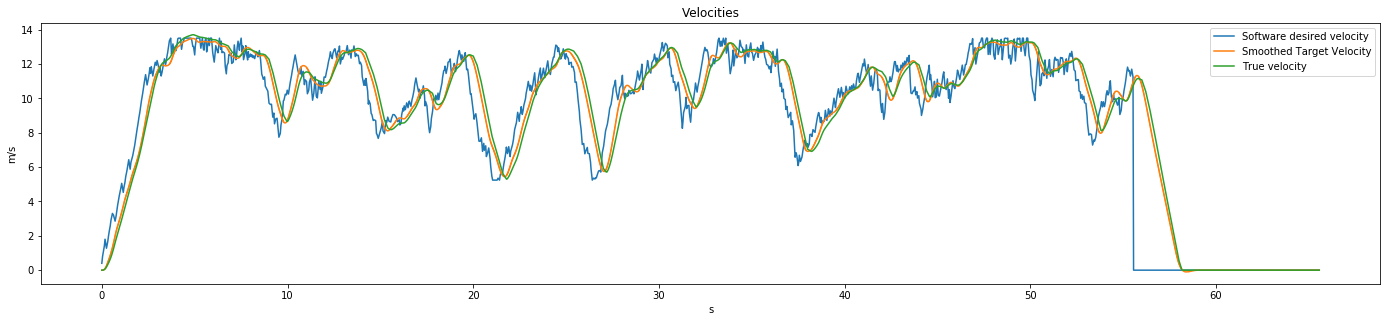

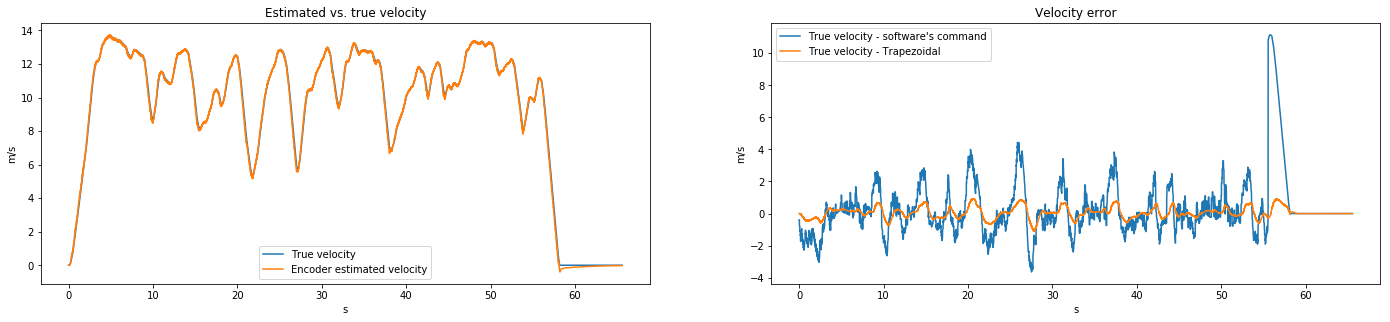

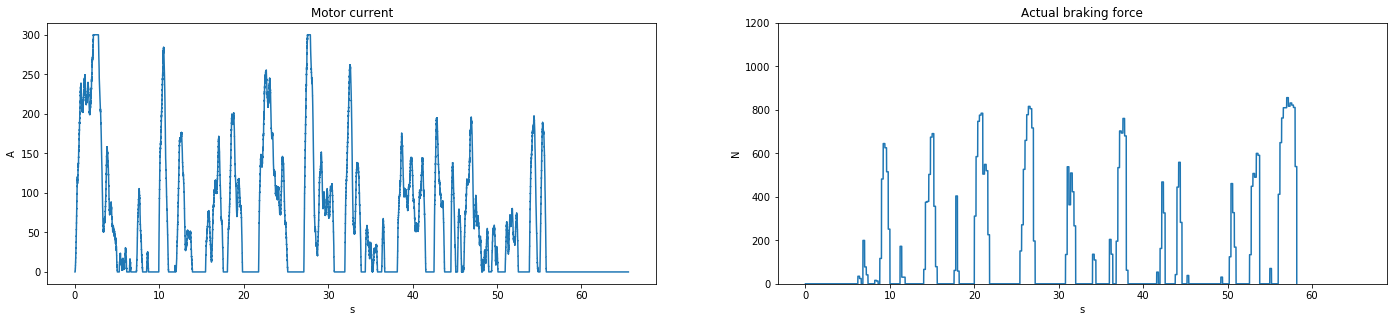

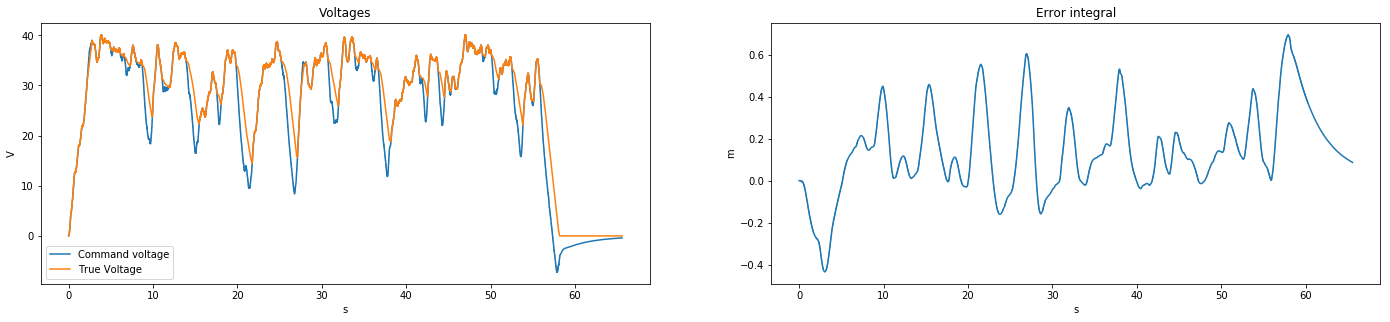

RMS current value: 99.17867875488524
Average brake power dissipation: 1114.1571560080586
Fraction of time brakes and motor on simultaneously: 0.02100125


In [22]:
#Plots!
import matplotlib.pyplot as plt
plot_resolution = 10    #Only plot one of every [this] values to accelerate plotting

times_to_plot = times[::plot_resolution]
true_velocities_to_plot = vel_kart_arr[::plot_resolution]

plt.figure(1, figsize=(24, 4.8))
plt.plot(software_velocity_times_commands[:,0], software_velocity_times_commands[:,1])
plt.plot(times_to_plot, filtered_vel_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot)

plt.title("Velocities")
plt.ylabel("m/s")
plt.xlabel("s")
plt.legend(['Software desired velocity', 'Smoothed Target Velocity', 'True velocity'])

plt.show()

plt.figure(2, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, true_velocities_to_plot)
plt.plot(times_to_plot, estimated_vel_arr[::plot_resolution])

plt.title("Estimated vs. true velocity")
plt.legend(['True velocity', "Encoder estimated velocity"])
plt.ylabel("m/s")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, true_velocities_to_plot - software_command_velocities_at_timestep_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot - filtered_vel_arr[::plot_resolution])

plt.title("Velocity error")
plt.legend(["True velocity - software's command", 'True velocity - Trapezoidal'])
plt.ylabel("m/s")
plt.xlabel("s")

plt.show()

plt.figure(3, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, motor_current_arr[::plot_resolution])
plt.title("Motor current")
plt.ylabel("A")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, brake_realized_arr[::plot_resolution])
plt.ylim(0, 1200)
plt.title("Actual braking force")
plt.ylabel("N")
plt.xlabel("s")
plt.show()


plt.figure(4, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, voltage_cmd_arr[::plot_resolution])
plt.plot(times_to_plot, voltage_realized_arr[::plot_resolution])

plt.title("Voltages")
plt.ylabel("V")
plt.xlabel("s")
plt.legend(['Command voltage', 'True Voltage'])

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, error_integral_arr[::plot_resolution])

plt.title("Error integral")
plt.ylabel("m")
plt.xlabel("s")
plt.show()

#Print out some stats
stat_start_time = 10
stat_end_time = 50
off_threshold = 1
stat_start_idx = int(stat_start_time/dt)
stat_end_idx = int(stat_end_time/dt)

rms_current = np.sqrt(np.mean(motor_current_arr[stat_start_idx:stat_end_idx]**2))
avg_brake_power = np.mean(vel_kart_arr[stat_start_idx:stat_end_idx]*brake_realized_arr[stat_start_idx:stat_end_idx])
print("RMS current value:", rms_current)
print("Average brake power dissipation:", avg_brake_power)

brakes_motor_simultaneous = np.logical_and(motor_current_arr[stat_start_idx:stat_end_idx]>off_threshold, brake_realized_arr[stat_start_idx:stat_end_idx]>off_threshold)
print("Fraction of time brakes and motor on simultaneously:", np.mean(brakes_motor_simultaneous))